In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import differential_evolution, dual_annealing
import logging

# Define common configurations for platelet inventory
CONFIG = {
    'fixed_transaction_cost': 150,  # Cost per transaction
    'variable_transaction_cost': 5,  # Cost per unit transported
    'holding_cost': 5,  # Increased holding cost to penalize overstocking
    'shortage_cost': 100,  # Penalty per unit of unsatisfied demand
    'wastage_cost': 50,  # Increased wastage cost to penalize expiry
    'demand_mean': 30,  # Mean demand per day
    'demand_std': 15,  # Increased standard deviation for realistic variability
    'max_inventory': 300,  # Maximum inventory capacity
    'shelf_life': 5,  # Platelet shelf life in days
    'fixed_lead_time': 1  # Lead time for replenishment
}

# Set up logging
logging.basicConfig(level=logging.INFO)

# Demand generator
class HalfNormalGenerator:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def next(self):
        return max(0, np.random.normal(self.mean, self.std))

# Supply Chain Environment
class PlateletSupplyChainEnvironment:
    def __init__(self, config):
        self.config = config
        self.shelf_life = config['shelf_life']
        self.demand_generator = HalfNormalGenerator(config['demand_mean'], config['demand_std'])
        self.reset()

    def reset(self):
        self.inventory = 30
        self.inventory_ages = [0] * self.inventory
        self.orders = []
        self.total_cost = 0
        self.total_demand = 0
        self.total_filled_demand = 0
        self.total_waste = 0
        return self.inventory

    def step(self, order_quantity):
        demand = int(self.demand_generator.next())
        self.total_demand += demand
        filled_demand = min(demand, len(self.inventory_ages))
        self.inventory_ages = self.inventory_ages[filled_demand:]  # Remove fulfilled inventory
        self.total_filled_demand += filled_demand

        # Process wastage
        expired_units = self.inventory_ages.count(self.shelf_life)
        self.total_waste += expired_units
        self.inventory_ages = [age + 1 for age in self.inventory_ages if age < self.shelf_life]

        # Process order
        if order_quantity > 0:
            order_quantity = int(order_quantity)
            self.inventory_ages.extend([0] * order_quantity)
            self.orders.append(order_quantity)
        else:
            self.orders.append(0)

        # Calculate costs
        fixed_cost = self.config['fixed_transaction_cost'] if order_quantity > 0 else 0
        variable_cost = self.config['variable_transaction_cost'] * order_quantity
        holding_cost = self.config['holding_cost'] * len(self.inventory_ages)
        lost_sales_cost = self.config['shortage_cost'] * (demand - filled_demand)
        wastage_cost = self.config['wastage_cost'] * expired_units

        total_cost = fixed_cost + variable_cost + holding_cost + lost_sales_cost + wastage_cost
        self.total_cost += total_cost

        reward = -total_cost
        return len(self.inventory_ages), reward, fixed_cost, variable_cost, holding_cost, lost_sales_cost, wastage_cost

# Train SQ and RS policies
class sQInventoryPolicy:
    def __init__(self, s, Q):
        self.s = s
        self.Q = Q

    # Adjusted logic for SQ policy to correctly evaluate inventory levels
    def order(self, inventory):
        return self.Q if inventory <= self.s else 0

class RSInventoryPolicy:
    def __init__(self, R, S):
        self.R = R
        self.S = S

    def order(self, inventory, timestep):
        return self.S - inventory if timestep % self.R == 0 and inventory <= self.S else 0

# SQ and RS Optimization
def rs_objective(params, training_data, config):
    R, S = params
    env = PlateletSupplyChainEnvironment(config)
    total_cost = 0
    policy = RSInventoryPolicy(R, S)
    for timestep, row in enumerate(training_data.itertuples()):
        state, demand = row.State, row.Demand
        order = policy.order(state, timestep)
        _, reward, *_ = env.step(order)
        total_cost -= reward
    return total_cost

def train_evaluate_rs_policy_optimized(training_data, config):
    bounds = [(1, 10), (10, config['max_inventory'])]
    result = dual_annealing(rs_objective, bounds=bounds, args=(training_data, config))
    return int(result.x[0]), int(result.x[1]), result.fun

def sq_objective(params, training_data, config):
    s, Q = params
    env = PlateletSupplyChainEnvironment(config)
    total_cost = 0
    policy = sQInventoryPolicy(s, Q)
    for _, row in training_data.iterrows():
        state, demand = row['State'], row['Demand']
        order = policy.order(state)
        _, reward, *_ = env.step(order)
        total_cost -= reward
    return total_cost

def train_evaluate_sq_policy_optimized(training_data, config):
    bounds = [(1, config['max_inventory'] // 3), (10, config['max_inventory'])]
    result = differential_evolution(sq_objective, bounds=bounds, args=(training_data, config))
    return int(result.x[0]), int(result.x[1]), result.fun

# Generate data
def generate_data(episodes, timesteps, config):
    env = PlateletSupplyChainEnvironment(config)
    data = []
    for _ in range(episodes):
        state = env.reset()
        for _ in range(timesteps):
            demand = env.demand_generator.next()
            data.append([state, demand])
    return pd.DataFrame(data, columns=['State', 'Demand'])

# Evaluate SQ and RS on Data (Generic Function for Training and Testing)
# Updated function to ensure all arrays in the results dictionary have consistent lengths.
def evaluate_policies_sq_and_rs(data, best_s, best_Q, best_R, best_S, config):
    env = PlateletSupplyChainEnvironment(config)
    results = {
        "demand": [], "sq_filled": [], "rs_filled": [], "lost_demand": [],
        "sq_inventory": [], "rs_inventory": [], "sq_orders": [], "rs_orders": [],
        "sq_costs": [], "rs_costs": [], "sq_waste": [], "rs_waste": [],
        "sq_fixed_cost": [], "rs_fixed_cost": [], "sq_variable_cost": [], "rs_variable_cost": [],
        "sq_holding_cost": [], "rs_holding_cost": [], "sq_wastage_cost": [], "rs_wastage_cost": [],
        "sq_shortage_cost": [], "rs_shortage_cost": []
    }

    sq_policy = sQInventoryPolicy(best_s, best_Q)
    rs_policy = RSInventoryPolicy(best_R, best_S)

    for timestep, row in data.iterrows():
        demand = row['Demand']
        results["demand"].append(demand)

        # SQ Policy
        sq_order = sq_policy.order(env.inventory)
        sq_inventory, sq_reward, sq_fixed, sq_variable, sq_holding, sq_shortage, sq_wastage = env.step(sq_order)
        sq_filled = min(demand, sq_inventory)
        results["sq_filled"].append(sq_filled)
        results["sq_orders"].append(sq_order)
        results["sq_inventory"].append(sq_inventory)
        results["sq_fixed_cost"].append(sq_fixed)
        results["sq_variable_cost"].append(sq_variable)
        results["sq_holding_cost"].append(sq_holding)
        results["sq_shortage_cost"].append(sq_shortage)
        results["sq_wastage_cost"].append(sq_wastage)
        results["sq_costs"].append(sq_fixed + sq_variable + sq_holding + sq_shortage + sq_wastage)

        # RS Policy
        rs_order = rs_policy.order(env.inventory, timestep)
        rs_inventory, rs_reward, rs_fixed, rs_variable, rs_holding, rs_shortage, rs_wastage = env.step(rs_order)
        rs_filled = min(demand, rs_inventory)
        results["rs_filled"].append(rs_filled)
        results["rs_orders"].append(rs_order)
        results["rs_inventory"].append(rs_inventory)
        results["rs_fixed_cost"].append(rs_fixed)
        results["rs_variable_cost"].append(rs_variable)
        results["rs_holding_cost"].append(rs_holding)
        results["rs_shortage_cost"].append(rs_shortage)
        results["rs_wastage_cost"].append(rs_wastage)
        results["rs_costs"].append(rs_fixed + rs_variable + rs_holding + rs_shortage + rs_wastage)

    # Ensure all arrays in the results dictionary have the same length
    max_length = max(len(values) for values in results.values())
    for key, values in results.items():
        if len(values) < max_length:
            results[key].extend([0] * (max_length - len(values)))

    # Fill rate and service cycle level
    results["sq_fill_rate"] = sum(results["sq_filled"]) / sum(results["demand"]) if sum(results["demand"]) > 0 else 0
    results["sq_service_cycle"] = len([f for f in results["sq_filled"] if f > 0]) / len(results["sq_filled"]) if len(results["sq_filled"]) > 0 else 0
    results["sq_waste"] = sum(results["sq_wastage_cost"]) / config["wastage_cost"]

    results["rs_fill_rate"] = sum(results["rs_filled"]) / sum(results["demand"]) if sum(results["demand"]) > 0 else 0
    results["rs_service_cycle"] = len([f for f in results["rs_filled"] if f > 0]) / len(results["rs_filled"]) if len(results["rs_filled"]) > 0 else 0
    results["rs_waste"] = sum(results["rs_wastage_cost"]) / config["wastage_cost"]

    return pd.DataFrame(results), results

In [2]:
# Generate data
def generate_data(episodes, timesteps, config):
    env = PlateletSupplyChainEnvironment(config)
    data = []
    for _ in range(episodes):
        state = env.reset()
        for _ in range(timesteps):
            demand = env.demand_generator.next()
            data.append([state, demand])
    return pd.DataFrame(data, columns=['State', 'Demand'])

In [3]:
training_data = generate_data(36, 30, CONFIG)
training_data.to_excel("training_data.xlsx", index=False)
# Train SQ and RS Policies
best_s, best_Q, best_cost_sq = train_evaluate_sq_policy_optimized(training_data, CONFIG)
best_R, best_S, best_cost_rs = train_evaluate_rs_policy_optimized(training_data, CONFIG)

# Evaluate Policies on Training Data
training_results_df, training_summary = evaluate_policies_sq_and_rs(training_data, best_s, best_Q, best_R, best_S, CONFIG)
training_results_df.to_excel("training_results.xlsx", index=False)

In [5]:
# Print Summary of Results
print("\n--- Training Data Results ---")
print(f"Optimal s: {best_s}, Optimal Q: {best_Q}")
print(f"Total SQ Policy Cost: {sum(training_results_df['sq_costs'])}")
print(f"SQ Fill Rate: {training_summary['sq_fill_rate']:.2f}")
print(f"SQ Service Cycle Level: {training_summary['sq_service_cycle']:.2f}")
print(f"SQ Wastage: {training_summary['sq_waste']} units")
print(f"Optimal R: {best_R}, Optimal S: {best_S}")
print(f"Total RS Policy Cost: {sum(training_results_df['rs_costs'])}")
print(f"RS Fill Rate: {training_summary['rs_fill_rate']:.2f}")
print(f"RS Service Cycle Level: {training_summary['rs_service_cycle']:.2f}")
print(f"RS Wastage: {training_summary['rs_waste']} units")



--- Training Data Results ---
Optimal s: 68, Optimal Q: 28
Total SQ Policy Cost: 1578790
SQ Fill Rate: 0.92
SQ Service Cycle Level: 0.97
SQ Wastage: 812.0 units
Optimal R: 7, Optimal S: 256
Total RS Policy Cost: 1368915
RS Fill Rate: 0.79
RS Service Cycle Level: 0.88
RS Wastage: 7973.0 units


In [6]:

# Generate Training and Testing Data

testing_data = generate_data(6, 30, CONFIG)
testing_data.to_excel("testing_data.xlsx", index=False)

# Evaluate Policies on Testing Data
testing_results_df, testing_summary = evaluate_policies_sq_and_rs(testing_data, best_s, best_Q, best_R, best_S, CONFIG)
testing_results_df.to_excel("test_results.xlsx", index=False)


print("\n--- Testing Data Results ---")
print(f"Optimal s: {best_s}, Optimal Q: {best_Q}")
print(f"Total SQ Policy Cost: {sum(testing_results_df['sq_costs'])}")
print(f"SQ Fill Rate: {testing_summary['sq_fill_rate']:.2f}")
print(f"SQ Service Cycle Level: {testing_summary['sq_service_cycle']:.2f}")
print(f"SQ Wastage: {testing_summary['sq_waste']} units")
print(f"Optimal R: {best_R}, Optimal S: {best_S}")
print(f"Total RS Policy Cost: {sum(testing_results_df['rs_costs'])}")
print(f"RS Fill Rate: {testing_summary['rs_fill_rate']:.2f}")
print(f"RS Service Cycle Level: {testing_summary['rs_service_cycle']:.2f}")
print(f"RS Wastage: {testing_summary['rs_waste']} units")





--- Testing Data Results ---
Optimal s: 68, Optimal Q: 28
Total SQ Policy Cost: 276600
SQ Fill Rate: 0.92
SQ Service Cycle Level: 0.96
SQ Wastage: 45.0 units
Optimal R: 7, Optimal S: 256
Total RS Policy Cost: 251065
RS Fill Rate: 0.82
RS Service Cycle Level: 0.84
RS Wastage: 1306.0 units


In [7]:
# Define DQNAgent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = []
        self.batch_size = 64
        self.model = self._build_model()
        # Add an attribute to store training losses
        self.training_losses = []

    def _build_model(self):
        model = Sequential([
            Input(shape=(self.state_size,)),  # Explicit Input layer
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=1)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        minibatch = [self.memory[i] for i in indices]

        states, targets = [], []
        for state, action, reward, next_state in minibatch:
            target = reward + self.gamma * np.amax(self.model.predict(next_state[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis], verbose=0)[0]
            target_f[action] = target
            states.append(state)
            targets.append(target_f)

        # Add loss to training_losses
        history = self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=1)
        self.training_losses.append(history.history['loss'][0])  # Change 2
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Updated train_evaluate_dqn_policy Function
def train_evaluate_dqn_policy(training_data, config, model_path="dqn_trained_model.h5"):
    env = PlateletSupplyChainEnvironment(config)
    state_size, action_size = 1, 10
    try:
      agent = DQNAgent(state_size, action_size)
      agent.model = tf.keras.models.load_model(model_path)
      logging.info("Loaded pre-trained model.")
    except:
      agent = DQNAgent(state_size, action_size)

    episodes = 40
    timesteps = 20

    dqn_filled, dqn_orders, dqn_costs = [], [], []
    rewards_per_episode = []

    for episode in range(episodes):
        state = np.array([env.reset()])
        total_reward = 0

        for _ in range(timesteps):
            dqn_action = agent.act(state)
            # Modified line: Unpack all 7 values returned by env.step()
            next_state, reward, _, _, _, _, _ = env.step(dqn_action)
            next_state = np.array([next_state])
            agent.remember(state, dqn_action, reward, next_state)
            state = next_state
            total_reward += reward

            dqn_filled.append(min(env.total_demand, env.inventory))
            dqn_orders.append(dqn_action)
            dqn_costs.append((env.total_cost, reward, env.inventory))

            agent.replay()

        rewards_per_episode.append(total_reward)
        # Print the reward for each episode
        print(f"Training Episode {episode + 1}/{episodes} total reward for this episode: {total_reward}")
    agent.model.save(model_path)
    logging.info("Model saved.")



    # Plot training loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(agent.training_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('DQN Training Loss Curve')
    plt.legend()
    plt.show()  # Change 4

    # Plot episodic reward curve
    plt.figure(figsize=(8, 5))
    plt.plot(rewards_per_episode, label='Episodic Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Episodic Reward Curve')
    plt.legend()
    plt.show()  # Change 5

    return agent, rewards_per_episode, dqn_filled, dqn_orders, dqn_costs

Training Episode 1/40 total reward for this episode: -48895
Training Episode 2/40 total reward for this episode: -58560
Training Episode 3/40 total reward for this episode: -51460
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 813247.2500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 863251.8125 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 845156.0625 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 853714.3125 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 870519.7500 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 830273.5000 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 935509.7500 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 865703.0000 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 893024.3750 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 945616.5625  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 865266.6875 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 853899.0625 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 851900.6875 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 997707.0625  
2/2 ━━

Training Episode 40/40 total reward for this episode: -56005


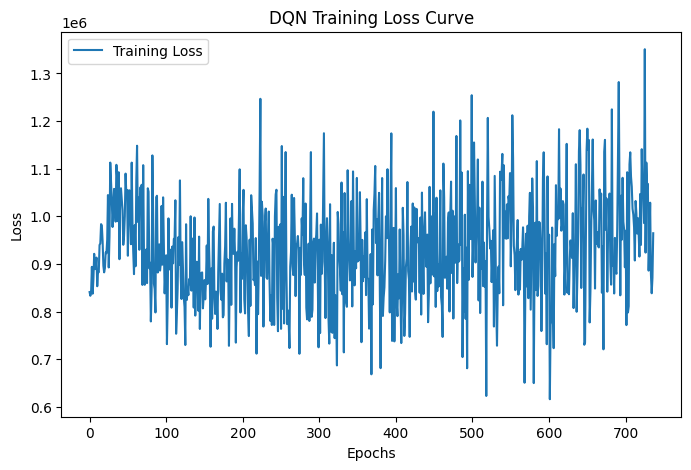

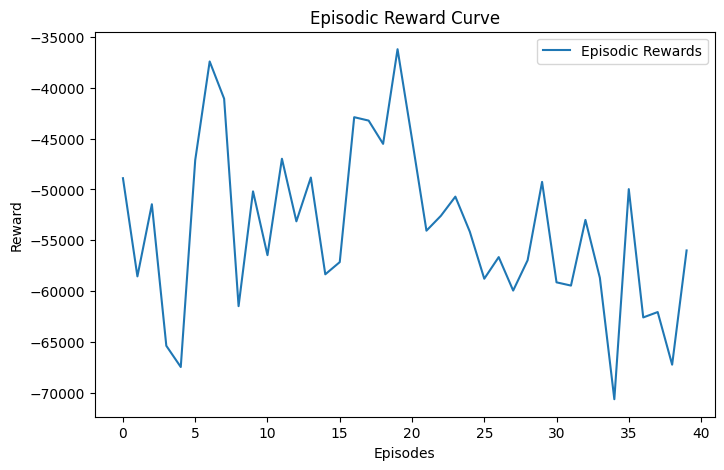

ValueError: too many values to unpack (expected 2)

In [8]:

rltraining_results_df, rltraining_summary_summary = train_evaluate_dqn_policy(training_data, CONFIG)
rltraining_results_df.to_excel("rltraining_results.xlsx", index=False)
logging.info("DQN Policy trained.")
